In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect
import random


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation,get_intracluster_distances,get_intercluster_distances
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [2]:
#allStar =  load("allStar_training_clean")
#dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
allStar =  load("allStar_occamlike")
dataset=  AspcapDataset(filename="aspcap_occamlike",tensor_type=torch.FloatTensor,recenter=True)
n_data=40000

(array([ 142.,  823., 2210., 2574., 2657., 3965., 5573., 7109., 7291.,
        7656.]),
 array([4002.9521, 4102.6543, 4202.3564, 4302.059 , 4401.761 , 4501.4634,
        4601.1655, 4700.8677, 4800.5703, 4900.2725, 4999.9746],
       dtype=float32),
 <a list of 10 Patch objects>)

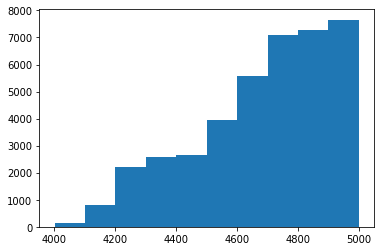

In [3]:
plt.hist(allStar["Teff"])

(array([ 388., 1485., 2377., 2389., 2693., 4303., 5431., 6800., 6676.,
        7079.]),
 array([4070.7532, 4163.6753, 4256.5977, 4349.5195, 4442.442 , 4535.364 ,
        4628.286 , 4721.208 , 4814.1304, 4907.0522, 4999.9746],
       dtype=float32),
 <a list of 10 Patch objects>)

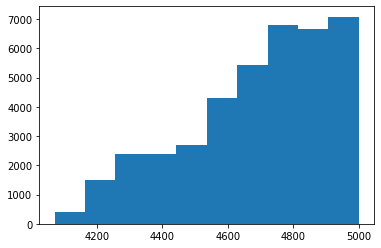

In [6]:
plt.hist(allStar["Teff"][:n_data][combined_cut[:n_data]])

In [5]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
n_outliercut = allStar["N_FE"]>-5
ni_outliercut = allStar["Ni_FE"]>-5
mn_outliercut = allStar["Mn_FE"]>-5


combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & s_outliercut & cr_outliercut & si_outliercut & n_outliercut & ni_outliercut & mn_outliercut


In [37]:
considered_parameters = ["Teff","logg","Fe_H","C_FE","N_FE","O_FE","Na_FE","Mg_FE","Al_FE","Si_FE","S_FE","Ni_FE","Cr_FE"] 
#considered_parameters = ["Fe_H"]
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [8]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])
occam_cluster_idxs = occam["cluster_idxs"]


### working with y

In [78]:
considered_parameters

['Teff',
 'logg',
 'Fe_H',
 'C_FE',
 'N_FE',
 'O_FE',
 'Na_FE',
 'Mg_FE',
 'Al_FE',
 'Si_FE',
 'S_FE',
 'Ni_FE',
 'Cr_FE']

In [38]:
y_occam = vector.Vector(np.array([allStar_occam[param] for param in considered_parameters])[:,:n_data].T)
y_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=y_occam(),order=1,interaction_only=False)

In [39]:
np.argwhere(y_occam()==np.min(y_occam()))

array([[103,  12]])

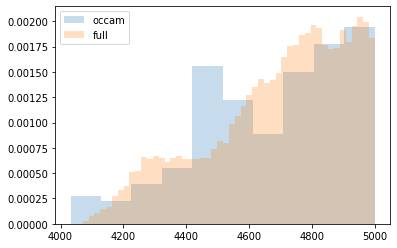

In [10]:
plt.hist(y_occam()[:,0],alpha=0.25,density=True,label="occam")
plt.hist(y()[:,0],alpha=0.25,density=True,label="full",bins=50)
plt.legend()

In [11]:
kept_idxs = np.argsort(np.abs(y_occam.cluster_centered()[:,0]))[:-2]

occam: 27200.99879782375
raw: 48714.3359375
ratio: 1.7909024701474363
here


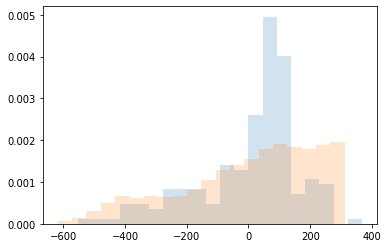

In [12]:
summarize_representation(y.centered()[:,0],y_occam.cluster_centered()[:,0][kept_idxs],0,0)

We delete the outlier stars

In [41]:
y_occam = vector.Vector(np.array([allStar_occam[param] for param in considered_parameters])[:,:n_data].T)
y_occam = vector.OccamLatentVector(occam_cluster_idxs[kept_idxs],raw=y_occam()[kept_idxs],order=1,interaction_only=False)

In [80]:
distances_y = get_intracluster_distances(y_occam,y_occam,use_relative_scaling=True)
random_distances_y = get_intercluster_distances(y_occam,y_occam,n_random=1000,use_relative_scaling=True)

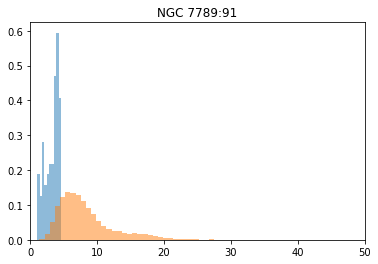

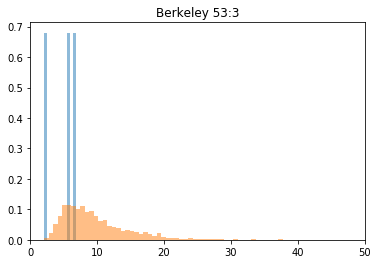

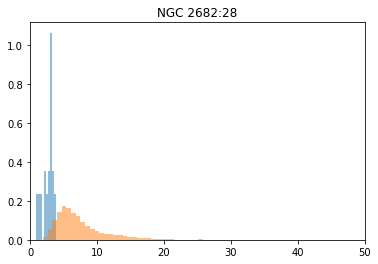

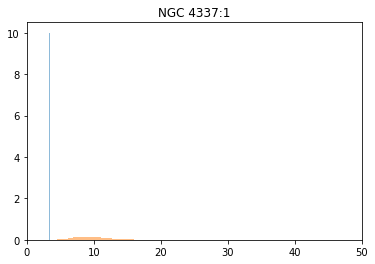

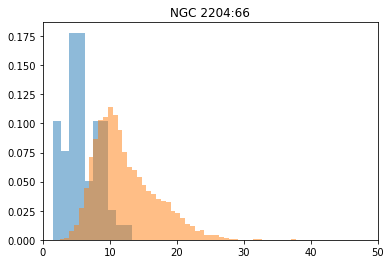

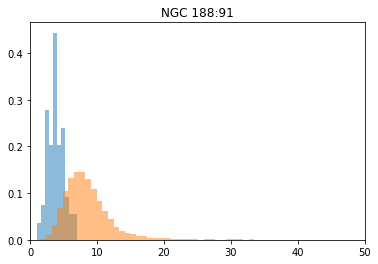

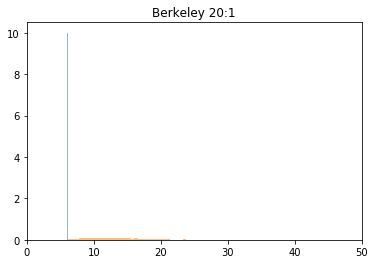

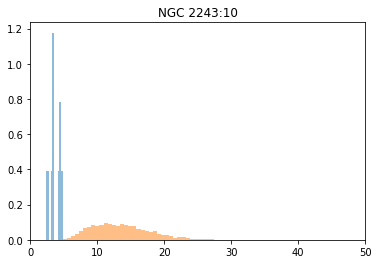

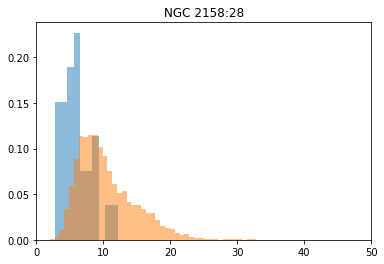

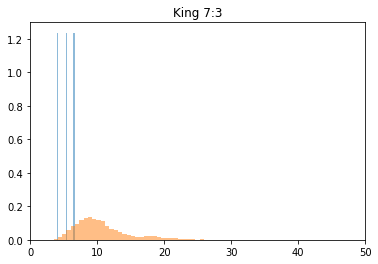

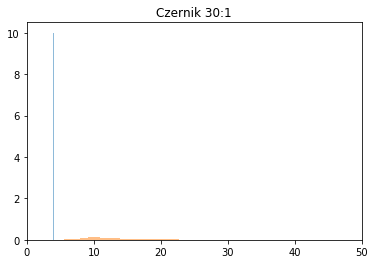

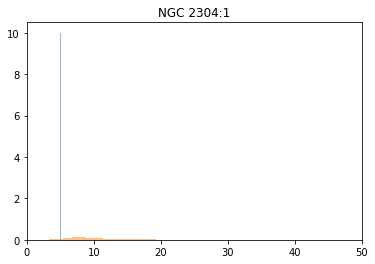

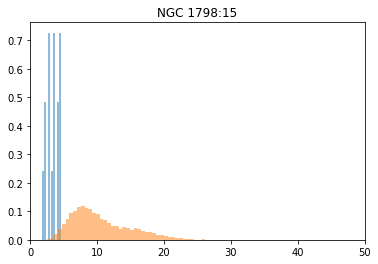

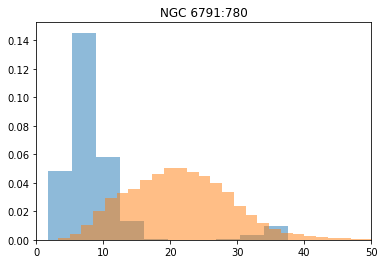

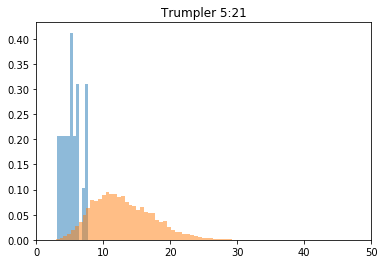

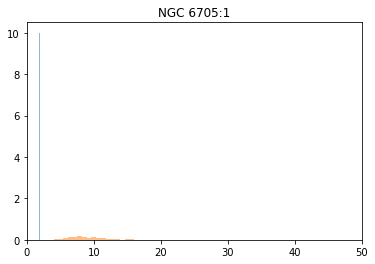

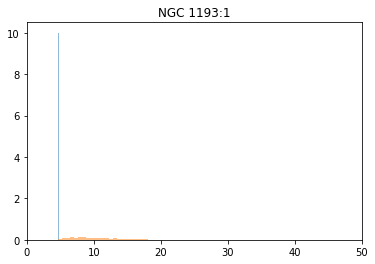

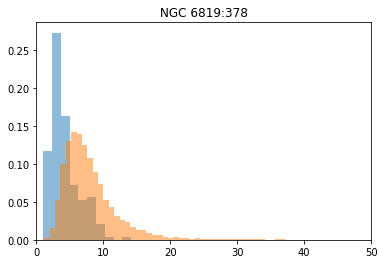

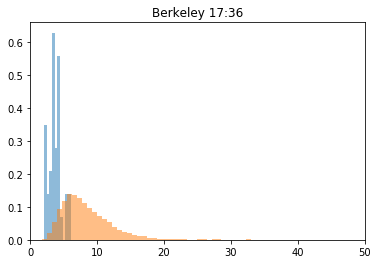

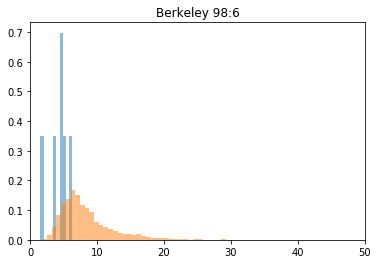

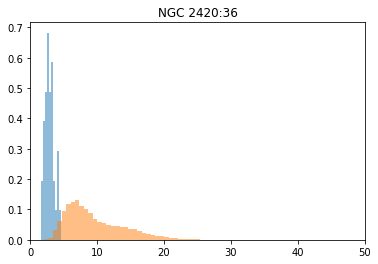

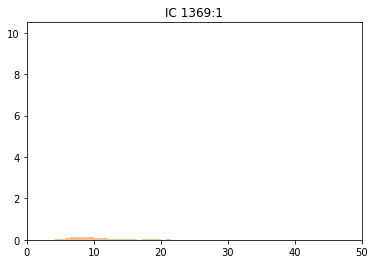

In [43]:
for i in range(len(distances_y)):
    plt.title(f"{list(y_occam.registry)[i]}:{len(distances_y[i])}")
    plt.hist(distances_y[i],alpha=0.5,density=True,bins=10)
    plt.hist(random_distances_y[i],alpha=0.5,density=True,bins=60)
    plt.xlim(0,50)
    plt.show()

In [45]:
for i in range(len(distances_y)):
    doppelganger_rate = np.mean(random_distances_y[i]<np.median(distances_y[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])
    print(f"cluster:{cluster_name}, doppelganger rate:{doppelganger_rate}, num_stars:{num_stars}")

cluster:NGC 7789, doppelganger rate:0.046142857142857145, num_stars:14
cluster:Berkeley 53, doppelganger rate:0.206, num_stars:3
cluster:NGC 2682, doppelganger rate:0.028, num_stars:8
cluster:NGC 4337, doppelganger rate:0.0, num_stars:2
cluster:NGC 2204, doppelganger rate:0.0155, num_stars:12
cluster:NGC 188, doppelganger rate:0.025857142857142856, num_stars:14
cluster:Berkeley 20, doppelganger rate:0.015, num_stars:2
cluster:NGC 2243, doppelganger rate:0.0, num_stars:5
cluster:NGC 2158, doppelganger rate:0.078625, num_stars:8
cluster:King 7, doppelganger rate:0.036, num_stars:3
cluster:Czernik 30, doppelganger rate:0.0005, num_stars:2
cluster:NGC 2304, doppelganger rate:0.06, num_stars:2
cluster:NGC 1798, doppelganger rate:0.004666666666666667, num_stars:6
cluster:NGC 6791, doppelganger rate:0.0144, num_stars:40
cluster:Trumpler 5, doppelganger rate:0.013571428571428571, num_stars:7
cluster:NGC 6705, doppelganger rate:0.0, num_stars:2
cluster:NGC 1193, doppelganger rate:0.011, num_sta

# Get the z's

In [46]:
allStar_occam["starflag"]

array([   0,    0,    0,    4,    0,    0,    0,    0,    0, 3072, 2048,
          0, 1536, 1536,  512,  512,  512,  516,    0,    0,  512,  512,
        512,  512,  512, 2064, 2064,    0,    0, 2048,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    4,    0,    0, 2048,    0,
          0, 1536,    0,  512,  512,  512,  512,  512,  512,  512,  512,
          0,    0,    0,    0,    0,    4,    4,    0,    0,    0,    0,
          0,    0,    0,    4,    4,    4,    4, 2048,    0,    0,    0,
          4,    0,    0,  512,    0,    0,    0,    0,  512,    0,    0,
          0,    0,    0, 1536,    0,    0,    0,    0, 3072,  512,    0,
       3072,  516,  512, 3072,  512,  512,  512,  512, 4608, 3072,  512,
       4612,  512, 3072,  512, 2048, 3072,  512,  512,  512,  512,  520,
        512, 2048, 4608,  512, 2048,  512,  512,  512,  512,    0,  512,
       2048, 2048,    0, 3072, 2048,    0, 2048, 2052, 2048,    0,    0,
          0, 2052,    0,    0,    0,    0, 2048,   

In [47]:
compressor = PCA(n_components=50,whiten=False)#z.raw.shape[1],whiten=True)
compressor.fit(dataset.dataset["aspcap_interpolated"])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [48]:
compressor.fit(dataset.dataset["aspcap_interpolated"])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

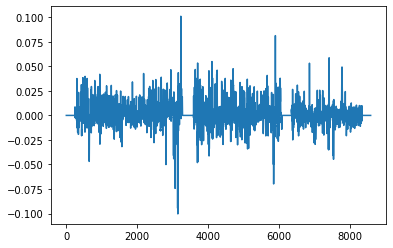

In [49]:
plt.plot(compressor.components_[3])

In [59]:
z_pca = compressor.transform(dataset.dataset["aspcap_interpolated"])
z_pca= z_pca[:n_data]
z_y = vector.Vector(z_pca[combined_cut[:n_data]],order=1,interaction_only=False)
z = vector.Vector(z_y(),order=1,interaction_only=False)

(1000, 1200)

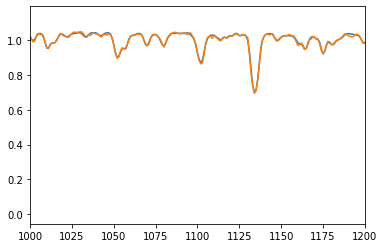

In [62]:
plt.plot(compressor.inverse_transform(z_pca)[450])
plt.plot(dataset.dataset["aspcap_interpolated"][450])
plt.xlim(1000,1200)

In [63]:
z_raw_occam = compressor.transform(dataset_occam.dataset["aspcap_interpolated"])
z_occam = vector.OccamLatentVector(occam_cluster_idxs[kept_idxs],raw=z_raw_occam[kept_idxs],order=1,interaction_only=False)

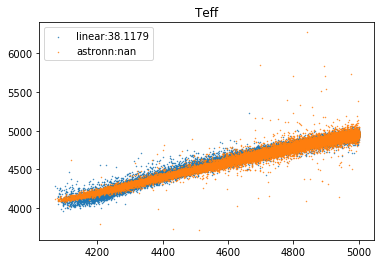

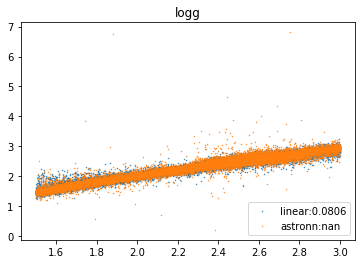

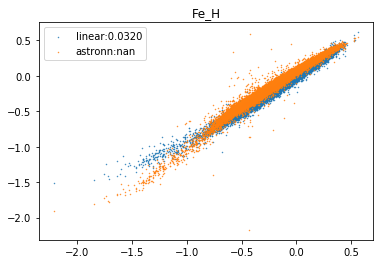

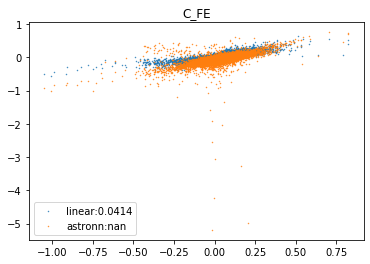

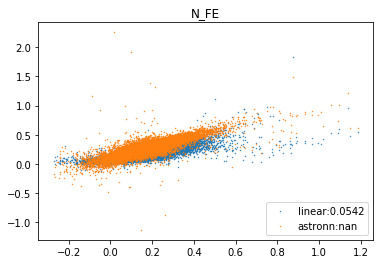

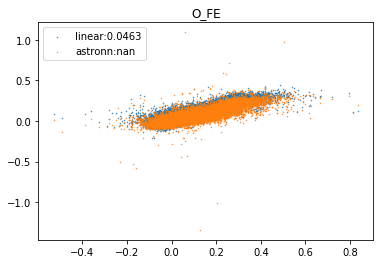

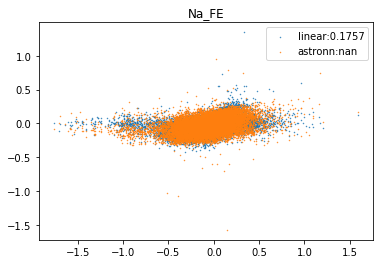

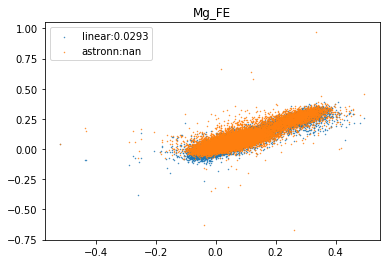

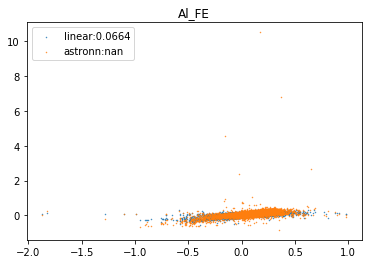

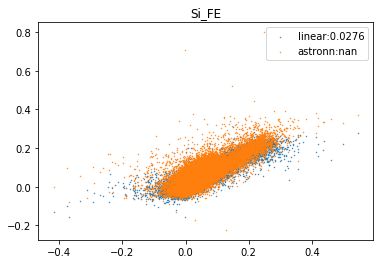

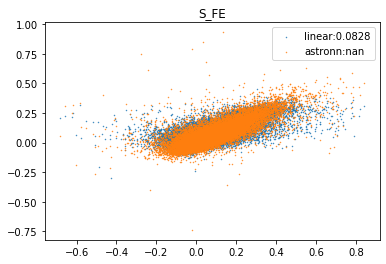

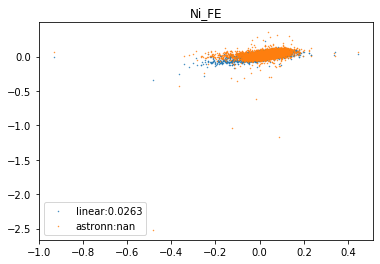

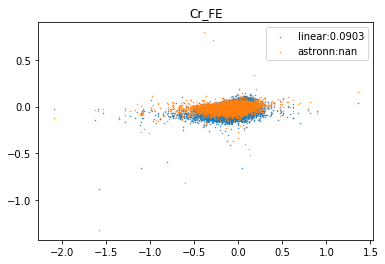

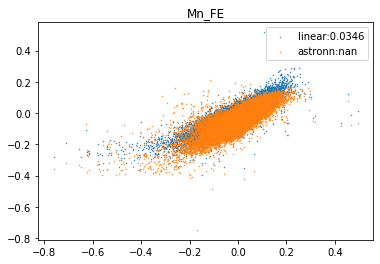

In [24]:
w = vector.LinearTransformation(z_y,y)
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    linear_std = np.std(w.predict(z_y).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_y).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

### Use the fitter object

In [90]:
fitter = vector.Fitter(z,z_occam,use_relative_scaling=True)
#fitter = vector.Fitter(z,z_occam.without("NGC 6819"))

In [91]:
fitter.scaling_factor

array([70.70537471, 70.70537471, 70.70537471, 70.70537471, 70.70537471,
       70.70537471, 70.70537471, 70.70537471, 70.70537471, 70.70537471,
        2.75089739,  2.05230451,  1.77184264,  1.5232285 ,  1.40681512,
        1.26245161,  1.06080944,  0.91616977,  0.90030524,  0.8333587 ,
        0.78645569,  0.76771116,  0.71762788,  0.69989586,  0.62976172,
        0.59208983,  0.58169733,  0.56392633,  0.55264713,  0.50515086,
        0.50075143,  0.47295963,  0.4428826 ,  0.42339269,  0.39161916,
        0.37809207,  0.36567839,  0.34267787,  0.31683883,  0.28944693,
        0.28162387,  0.26151287,  0.24724588,  0.22468538,  0.21373046,
        0.18756217,  0.18389856,  0.15684968,  0.12522435,  0.10593324])

In [66]:
v_centered_occam = fitter.transform(z_occam.centered.only("NGC 6819"))
v = fitter.transform(fitter.z.centered)

occam: 0.5914023813179582
raw: 80.53186998115783
ratio: 136.1710275864803


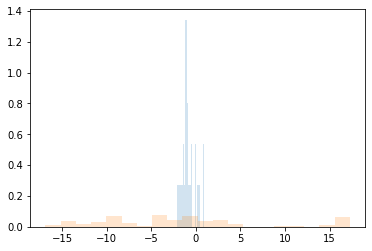

In [67]:
summarize_representation(v[:,49],v_centered_occam[:,49],0.1,0.1)

In [79]:
#distances = get_intracluster_distances(z,z_occam.without("NGC 6791"))
#random_distances = get_intercluster_distances(z,z_occam.without("NGC 6791"))
distances = get_intracluster_distances(z_occam,z_occam,use_relative_scaling=True)
random_distances = get_intercluster_distances(z_occam,z_occam,n_random=1000,use_relative_scaling=True)

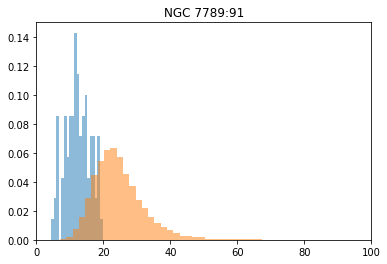

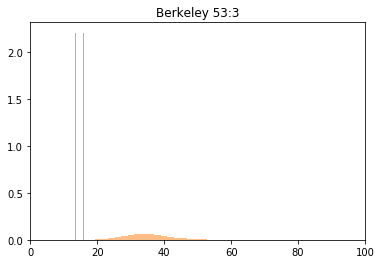

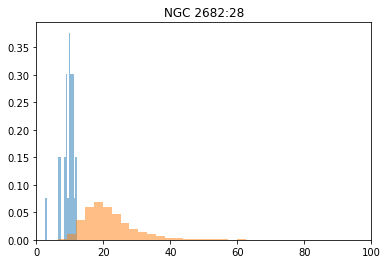

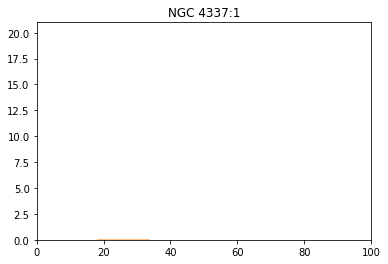

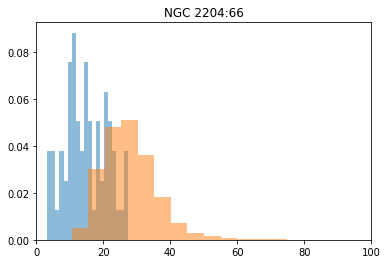

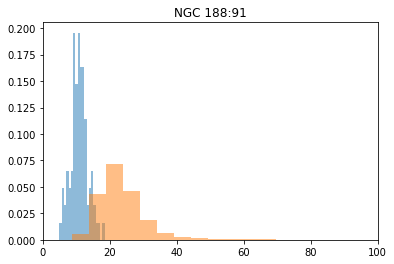

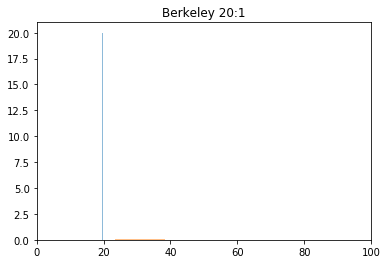

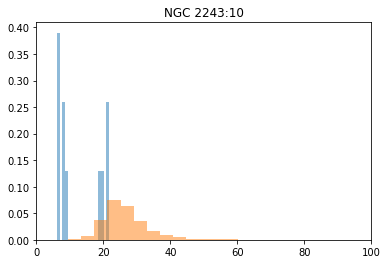

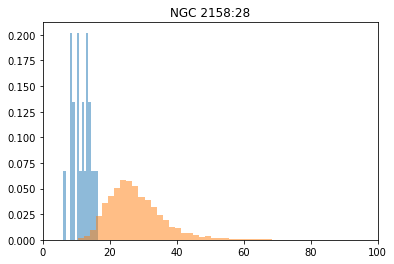

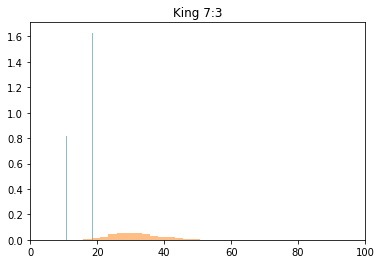

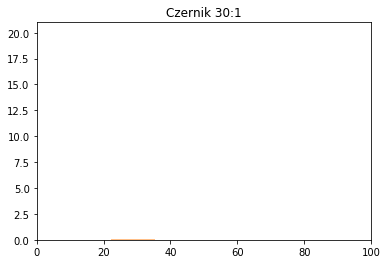

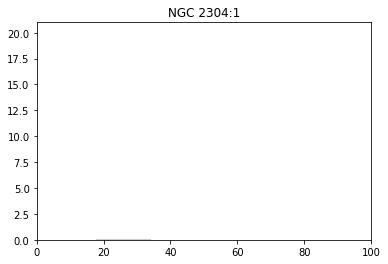

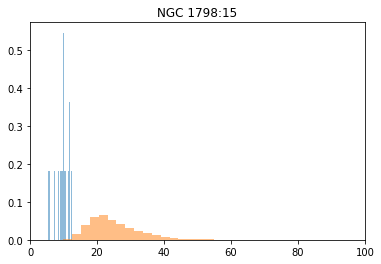

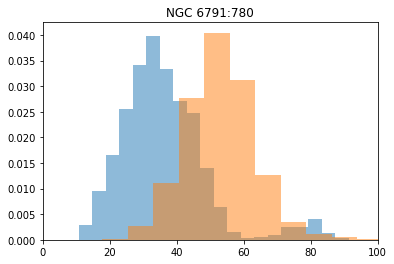

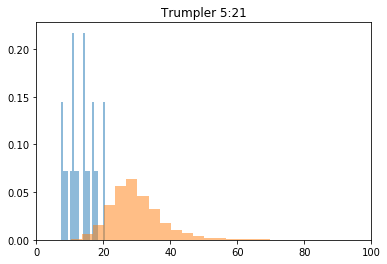

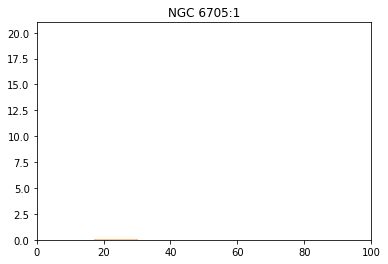

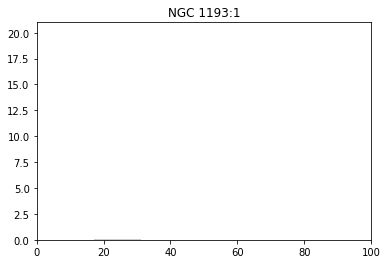

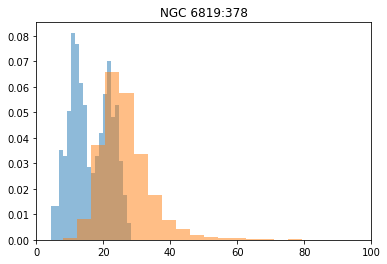

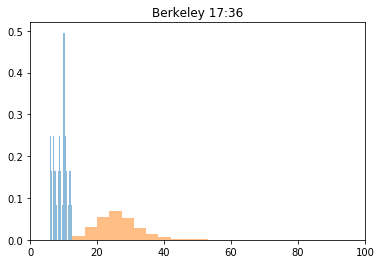

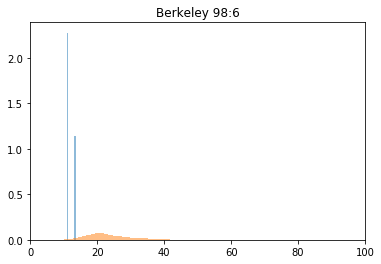

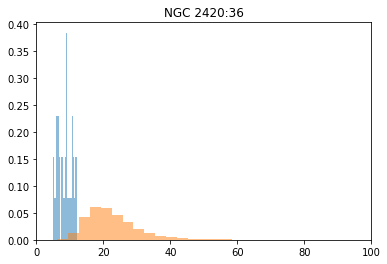

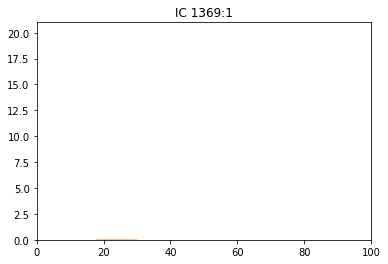

In [72]:
for i in range(len(distances)):
    plt.title(f"{list(z_occam.registry)[i]}:{len(distances[i])}")
    plt.hist(distances[i],alpha=0.5,density=True,bins=20)
    plt.hist(random_distances[i],alpha=0.5,density=True,bins=50)
    plt.xlim(0,100)
    plt.show()

In [ ]:
def get_doppelgangers(distances,random_distances,registry=None,verbose=True):
    """return doppelganger rate per cluster. Also prints it if in verbose mode
    """
    doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])

In [70]:
for i in range(len(distances)):
    doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])
    print(f"cluster:{cluster_name}, doppelganger rate:{doppelganger_rate}, num_stars:{num_stars}")

cluster:NGC 7789, doppelganger rate:0.012785714285714286, num_stars:14
cluster:Berkeley 53, doppelganger rate:0.0003333333333333333, num_stars:3
cluster:NGC 2682, doppelganger rate:0.007, num_stars:8
cluster:NGC 4337, doppelganger rate:0.0, num_stars:2
cluster:NGC 2204, doppelganger rate:0.012, num_stars:12
cluster:NGC 188, doppelganger rate:0.001142857142857143, num_stars:14
cluster:Berkeley 20, doppelganger rate:0.0135, num_stars:2
cluster:NGC 2243, doppelganger rate:0.0002, num_stars:5
cluster:NGC 2158, doppelganger rate:0.00175, num_stars:8
cluster:King 7, doppelganger rate:0.01633333333333333, num_stars:3
cluster:Czernik 30, doppelganger rate:0.0, num_stars:2
cluster:NGC 2304, doppelganger rate:0.1045, num_stars:2
cluster:NGC 1798, doppelganger rate:0.0, num_stars:6
cluster:NGC 6791, doppelganger rate:0.033325, num_stars:40
cluster:Trumpler 5, doppelganger rate:0.003857142857142857, num_stars:7
cluster:NGC 6705, doppelganger rate:0.0, num_stars:2
cluster:NGC 1193, doppelganger rat

In [71]:
for i in range(len(distances_y)):
    doppelganger_rate = np.mean(random_distances_y[i]<np.median(distances_y[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])
    print(f"cluster:{cluster_name}, doppelganger rate:{doppelganger_rate}, num_stars:{num_stars}")

cluster:NGC 7789, doppelganger rate:0.046142857142857145, num_stars:14
cluster:Berkeley 53, doppelganger rate:0.206, num_stars:3
cluster:NGC 2682, doppelganger rate:0.028, num_stars:8
cluster:NGC 4337, doppelganger rate:0.0, num_stars:2
cluster:NGC 2204, doppelganger rate:0.0155, num_stars:12
cluster:NGC 188, doppelganger rate:0.025857142857142856, num_stars:14
cluster:Berkeley 20, doppelganger rate:0.015, num_stars:2
cluster:NGC 2243, doppelganger rate:0.0, num_stars:5
cluster:NGC 2158, doppelganger rate:0.078625, num_stars:8
cluster:King 7, doppelganger rate:0.036, num_stars:3
cluster:Czernik 30, doppelganger rate:0.0005, num_stars:2
cluster:NGC 2304, doppelganger rate:0.06, num_stars:2
cluster:NGC 1798, doppelganger rate:0.004666666666666667, num_stars:6
cluster:NGC 6791, doppelganger rate:0.0144, num_stars:40
cluster:Trumpler 5, doppelganger rate:0.013571428571428571, num_stars:7
cluster:NGC 6705, doppelganger rate:0.0, num_stars:2
cluster:NGC 1193, doppelganger rate:0.011, num_sta

In [81]:
for i in range(len(distances)):
    doppelganger_z = np.mean(random_distances[i]<np.median(distances[i]))
    doppelganger_y = np.mean(random_distances_y[i]<np.median(distances_y[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])
    print(f"cluster:{cluster_name} ({num_stars} stars), doppelganger_z:{doppelganger_z}, doppelganger_abundances:{doppelganger_y} ")


cluster:NGC 7789 (14 stars), doppelganger_z:0.05392857142857143, doppelganger_abundances:0.08257142857142857 
cluster:Berkeley 53 (3 stars), doppelganger_z:0.007, doppelganger_abundances:0.259 
cluster:NGC 2682 (8 stars), doppelganger_z:0.044, doppelganger_abundances:0.097625 
cluster:NGC 4337 (2 stars), doppelganger_z:0.0055, doppelganger_abundances:0.0065 
cluster:NGC 2204 (12 stars), doppelganger_z:0.05508333333333333, doppelganger_abundances:0.10575 
cluster:NGC 188 (14 stars), doppelganger_z:0.038214285714285715, doppelganger_abundances:0.05228571428571428 
cluster:Berkeley 20 (2 stars), doppelganger_z:0.0145, doppelganger_abundances:0.066 
cluster:NGC 2243 (5 stars), doppelganger_z:0.0154, doppelganger_abundances:0.0206 
cluster:NGC 2158 (8 stars), doppelganger_z:0.0275, doppelganger_abundances:0.140125 
cluster:King 7 (3 stars), doppelganger_z:0.04533333333333334, doppelganger_abundances:0.058 
cluster:Czernik 30 (2 stars), doppelganger_z:0.005, doppelganger_abundances:0.011 
cl

In [ ]:
for i in range(len(distances)):
    doppelganger_rate = np.mean(random_distances[i]<np.median(distances[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])
    print(f"cluster:{cluster_name}, doppelganger rate:{doppelganger_rate}, num_stars:{num_stars}")

In [ ]:
for i in range(len(distances_y)):
    doppelganger_rate = np.mean(random_distances_y[i]<np.median(distances_y[i]))
    cluster_name = list(y_occam.registry)[i]
    num_stars = len(y_occam.registry[cluster_name])
    print(f"cluster:{cluster_name}, doppelganger rate:{doppelganger_rate}, num_stars:{num_stars}")

In [ ]:
def get_combinations(len_cluster):
    """
    Given a cluster size returns a list containing every pair of index (without repeat) 
    """
    combinations = []
    for idx1 in np.arange(len_cluster):
        for idx2 in np.delete(np.arange(len_cluster),idx1):
            if sorted([idx1,idx2]) not in combinations:
                combinations.append(sorted([idx1,idx2]))
    return combinations




In [ ]:
def get_selfintracluster_distances(z_occam,leave_out=True):
    """Measures intracluster distances (between stars in the same cluster) after fitting and transforming.
    INPUTS                                                                       
    ------                                                                       
    z: apoNN.vector.Vector                                                       
        A vector containing the field star dataset                               
    z_occam: vector.OccamLatentVector                                            
        A vector containing the occam cluster stars                              
    leave_out: Boolean                                                           
        True corresponds to excluding clusters being evaluated from training so as to avoid overfitting 
    """
    distances = []                                                               
    for cluster in list(z_occam.registry.keys()):                                
        if leave_out is True:
            fitter = vector.Fitter(z_occam.without(cluster),z_occam.without(cluster))                   
        else:
            fitter = vector.Fitter(z_occam,z_occam)                                    
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))      
        combinations = get_combinations(len(v_centered_occam))
        distances_cluster = []
        for combination in combinations:                                         
            distances_cluster.append(np.linalg.norm(v_centered_occam[combination[0]]-v_centered_occam[combination[1]]))
            
        distances.append(distances_cluster)                                      
    return distances                                                             
        
    


In [ ]:
def get_selfintercluster_distances(z,z_occam,leave_out=True,n_random = 200):
    """Measures intercluster distances (between stars in a cluster and stars from the field) after fitting and transforming
    INPUTS
    ------
    z: apoNN.vector.Vector
        A vector containing the field star dataset
    z_occam: vector.OccamLatentVector
        A vector containing the occam cluster stars
    leave_out: Boolean
        True corresponds to excluding clusters being evaluated from training so as to avoid overfitting 
    n_random: Number of field stars each cluste star is compared too.
    """
    distances = []
    for cluster in list(z_occam.registry.keys()):
        if leave_out is True:
            fitter = vector.Fitter(z_occam.without(cluster),z_occam.without(cluster))
        else:
            fitter = vector.Fitter(z_occam,z_occam)
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))
        v = fitter.transform(z.centered)
        n_v = len(v)
        distances_cluster = []
        for idx in np.arange(len(v_centered_occam)):
            for _ in np.arange(n_random):
                random_idx = random.randint(0,n_v-1)
                distances_cluster.append(np.linalg.norm(v_centered_occam[idx]-v[random_idx]))

        distances.append(distances_cluster)
    return distances


In [ ]:
distances = get_selfintracluster_distances(z_occam)
random_distances = get_selfintercluster_distances(z,z_occam,n_random=1000)

In [ ]:
def get_field_distances(z,z_occam,leave_out=True,n_random = 200,use_relative_scaling=True):
    """Measures intercluster distances (between stars in a cluster and stars from the field) after fitting and transforming
    INPUTS
    ------
    z: apoNN.vector.Vector
        A vector containing the field star dataset
    z_occam: vector.OccamLatentVector
        A vector containing the occam cluster stars
    leave_out: Boolean
        True corresponds to excluding clusters being evaluated from training so as to avoid overfitting 
    n_random: Number of field stars each cluste star is compared too.
    """
    distances = []
    for cluster in list(z_occam.registry.keys()):
        if leave_out is True:
            fitter = vector.Fitter(z,z_occam.without(cluster),use_relative_scaling=use_relative_scaling)
        else:
            fitter = vector.Fitter(z,z_occam,use_relative_scaling=use_relative_scaling)
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))
        v = fitter.transform(fitter.z.centered)
        n_v = len(v)
        distances_cluster = []
        for idx in np.arange(len(v_centered_occam)):
            for _ in np.arange(n_random):
                random_idx = random.randint(0,n_v-1)
                random_idx2 = random.randint(0,n_v-1)

                distances_cluster.append(np.linalg.norm(v_centered_occam[idx]-v[random_idx]))

        distances.append(distances_cluster)
    return distances
